
Цель работы - решение задач компьютерного зрения в системах управления с использованием предобученных моделей сверточных нейронных сетей из библиотеки PyTorch.

Преимущество предобученных моделей - получение быстрого результата без погружения в детали реализации и выполнения трудоемкого процесса настройки на крупных библиотеках изображений.

Их недостатки - возможны ограничения лицензий использования как на использованный при обучении набор данных, так и на сами коэффициенты из библиотеки и исходный код модели. Ещё одним недостатком является то, что такие весовые коэффицпенты расчитываются на публичных библиотеках изображений и зачастую могут оказаться нерелеванты решаемой задаче.

Последнюю проблему обычно решают с помощью набора приемов, известных в англоязычной литературе как "Transfer learning". Суть его состоит в использовании библиотечных коэффициентов и модели как базы для настройки новой модели.

Ниже будет проиллюстрировано решение задач классификации и донастройки модели с использованием библиотеки PyTorch.
В заданном варианте в качестве датасета используются изображения ротора турбины и коробки передач.

## 1. Инициализация преднастроенных нейросетевых моделей

Для 5 предобученных моделей (AlexNet, DenseNet, MobileNet, ResNet50, SwinT) провести сравнение процесса классификации на собранном датасете.

In [ ]:
from torchvision import models

alexNet = {
    # https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
    'model': models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    'weights': models.AlexNet_Weights.DEFAULT,
    'preprocess': models.AlexNet_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[1].in_features
}

resNet50 = {
    # https://arxiv.org/abs/1512.03385
    'model': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'weights': models.ResNet50_Weights.DEFAULT,
    'preprocess': models.ResNet50_Weights.DEFAULT.transforms(),
    'output_layer': 'fc',
    'in_features': lambda model: model.fc.in_features
}

denseNet = {
    # https://arxiv.org/abs/1608.06993
    'model': models.densenet201(weights=models.DenseNet201_Weights.DEFAULT),
    'weights': models.DenseNet201_Weights.DEFAULT,
    'preprocess': models.DenseNet201_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[0].in_features
}

mobileNetV3_small = {
    # https://arxiv.org/abs/1905.02244
    'model': models.mobilenet_v3_small(weights=models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT),
    'weights': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT,
    'preprocess': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT.transforms(),
    'output_layer': 'classifier',
    'in_features': lambda model: model.classifier[0].in_features
}

swinT = {
    # https://arxiv.org/abs/2103.14030
    'model': models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT),
    'weights': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT,
    'preprocess': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT.transforms(),
    'output_layer': 'head',
    'in_features': lambda model: model.head.in_features
}



Далее необходимо определиться с вычислительной подсистемой (CPU или GPU).

In [ ]:
import torch

gpu = 'has' if torch.cuda.is_available() else 'has no'
print(f'Current environment {gpu} GPU support')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!lscpu
print(f'GPU count = {torch.cuda.device_count() if torch.cuda.is_available() else "0"}')

for model in [resNet50, alexNet, denseNet, mobileNetV3_small, swinT]:
    model['model'].to(device)
    model['preprocess'].to(device)
    model['model'].eval()

## Вспомогательные функции

In [ ]:
import os
import time
import copy
import math

import typing
from typing import Callable
from functools import partial

import numpy
import pandas
from pandas.core.arrays import boolean
import matplotlib.pyplot as plt
from requests import get

from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToPILImage, Compose, Resize, CenterCrop
from torchvision.io import read_image
from torchvision.io import ImageReadMode


strip_chars = ' \t'
tmp_file_name = 'tmp_file_name_for_image_download'

to_image = ToPILImage()


def classify(dataset: Dataset,
                preprocess: typing.Callable[[Tensor],Tensor],
                num_per_row: int, single_size: float,
                labels: typing.List[str],
                model_labels: typing.List[str] = None,
                model: typing.Callable[[Tensor], Tensor] = None,
                debug: typing.Any = False,
                num_of_classes: int = 1,
                vspace: float = 0.3
             ) -> None:
    num = len(dataset)
    fig, axs = plt.subplots(math.ceil(num/num_per_row), num_per_row, figsize=(
        single_size*num_per_row, (single_size + vspace)*(math.ceil(num/num_per_row))),
        sharex=True, sharey=True)
    average = 0
    for i in range(0, len(dataset)):
        try:
            image, label = dataset[i]
            pred = None

            if model is not None and model_labels is not None:
                start_time = time.perf_counter_ns()
                score = model(image.unsqueeze(0)).detach().squeeze(0).softmax(0)
                pred_index = numpy.flip(score.detach().cpu().argsort().numpy())[0]
                end_time = time.perf_counter_ns()
                average += (end_time - start_time) / 1000000
                pred = f'Detector: {(end_time - start_time) / 1_000_000:.0f}ms\n{model_labels[pred_index]}[{score[pred_index].item()*100:.0f}%]'

            loc_fig = axs[i//num_per_row, i % num_per_row]
            loc_fig.imshow(to_image(preprocess(image)))
            title =f'\nActual: {labels[label]}[{label}]\n{pred}'
            loc_fig.title.set_text(title)
        except Exception as ex:
            if debug:
                raise ex
            print(f'Image {i} is failed to load: {str(ex)}')
    print('-' * 7)
    print('average: ' + str(average/len(dataset)) + ' s')
    print('-' * 7)
    fig.subplots_adjust(wspace=0.3)
    plt.show()


def denormalize(dataset: Dataset, trans: typing.Any) -> Callable[[Tensor], Tensor]:
    image, label = dataset[0]
    std = torch.as_tensor(trans.std, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    mean = torch.as_tensor(trans.mean, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    return lambda img: img*std + mean


class UrlDataset(Dataset):

    def __init__(self, file: str, to_device, transform = None) -> None:
        self.file = file
        self.transform = transform
        self.dataset = pandas.read_csv(file, sep=';')
        self.classes = self.dataset['label'].unique()
        self.classes.sort()
        self.class_to_index = {self.classes[i] : i for i in range(len(self.classes))}
        self.device = to_device

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, str]:
        url = self.dataset.iloc[index]['url'].strip(strip_chars)
        with open(tmp_file_name, 'wb') as file:
            file.write(get(url).content)
        image = read_image(tmp_file_name, ImageReadMode.RGB).to(self.device)
        label = self.class_to_index[self.dataset.iloc[index]['label']]
        if self.transform:
            return self.transform(image), label
        return image, label


def train_model(model, dataloader: DataLoader, device: torch.device,
                critery, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    best_epoch = -1

    process = {'train': {'loss': [], 'accuracy': []}, 'validate': {'loss': [], 'accuracy': []}}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_loss = 0.0
        epoch_acc = 0.0
        for item in dataloader:
            if item['train'] == True:
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            dataset_size = 0
            for inputs, labels in item['loader']:
                dataset_size = dataset_size + 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(item['train'] == True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = critery(outputs, labels)
                    if item['train'] == True:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if item['train'] == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.detach().cpu().double() / dataset_size

            if item['train'] == True:
                ptype = 'train'
            else:
                ptype = 'validate'

            process[ptype]['loss'].append(epoch_loss)
            process[ptype]['accuracy'].append(epoch_acc)

            print(f'[{epoch}][train={item["train"]}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if item['train'] == True and 1/epoch_loss > best_loss:
                best_loss = 1/epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {1/best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, process


## Пример описания данных для классификации

Подготовим датасет, состоящий из 50 изображений ротор турбины и 50 изображений коробки передач. набор данных (датасет) формализуется в виде CSV-файла, содержащего URL изображения из интернета и вручную назначенных меток объектов (названий классов), к которому каждое изображение относится.

In [ ]:
%%writefile simple.csv
label;url
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_1?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_2?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_3?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_4?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_5?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_6?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_7?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_8?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_9?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_10?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_1?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_2?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_3?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_4?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_5?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_6?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_7?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_8?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_9?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_10?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_11?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_12?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_13?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_14?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_15?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_16?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_17?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_18?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_19?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_20?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_21?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_22?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_23?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_24?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_25?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_26?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_27?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_28?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_29?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_30?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_31?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_32?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_33?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_34?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_35?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_36?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_37?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_38?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_39?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_40?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_1?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_2?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_3?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_4?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_5?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_6?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_7?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_8?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_9?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_10?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_1?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_2?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_3?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_4?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_5?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_6?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_7?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_8?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_9?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_10?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_11?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_12?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_13?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_14?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_15?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_16?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_17?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_18?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_19?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_20?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_21?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_22?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_23?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_24?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_25?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_26?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_27?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_28?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_29?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_30?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_31?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_32?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_33?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_34?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_35?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_36?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_37?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_38?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_39?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_40?raw=true

## Классификация изображений с библиотечными коэффициентами

Для простоты сравнения создадим три одинаковых блоках для переключения между средами выполнения. Выполним построение на CPU.

CPU

In [ ]:
models = [alexNet, resNet50, denseNet, mobileNetV3_small, swinT]
for model in models:
  transform = model['preprocess']
  simple = UrlDataset("simple.csv", device, transform)
  print('-'*70)
  print(f'Model: { model["model"].__class__.__name__}')
  print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

  num_per_row = 5
  single_size = 3.5
  vspace = 0.4

  classify(simple, denormalize(simple, transform), num_per_row=num_per_row, single_size=single_size, vspace = vspace,
              labels = simple.classes, model=model['model'], model_labels=model['weights'].meta["categories"],
              debug=True)


GPU

In [ ]:
models = [alexNet, resNet50, denseNet, mobileNetV3_small, swinT]
for model in models:
  transform = model['preprocess']
  simple = UrlDataset("simple.csv", device, transform)
  print('-'*70)
  print(f'Model: { model["model"].__class__.__name__}')
  print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

  num_per_row = 5
  single_size = 3.5
  vspace = 0.4

  classify(simple, denormalize(simple, transform), num_per_row=num_per_row, single_size=single_size, vspace = vspace,
              labels = simple.classes, model=model['model'], model_labels=model['weights'].meta["categories"],
              debug=True)

TPU

In [ ]:
models = [alexNet, resNet50, denseNet, mobileNetV3_small, swinT]
for model in models:
  transform = model['preprocess']
  simple = UrlDataset("simple.csv", device, transform)
  print('-'*70)
  print(f'Model: { model["model"].__class__.__name__}')
  print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

  num_per_row = 5
  single_size = 3.5
  vspace = 0.4

  classify(simple, denormalize(simple, transform), num_per_row=num_per_row, single_size=single_size, vspace = vspace,
              labels = simple.classes, model=model['model'], model_labels=model['weights'].meta["categories"],
              debug=True)

Построим график средней скорости классификации изображений для разных моделей (AlexNet, DenseNet, MobileNet, ResNet50, SwinT) и сред исполнения (CPU, GPU, TPU). 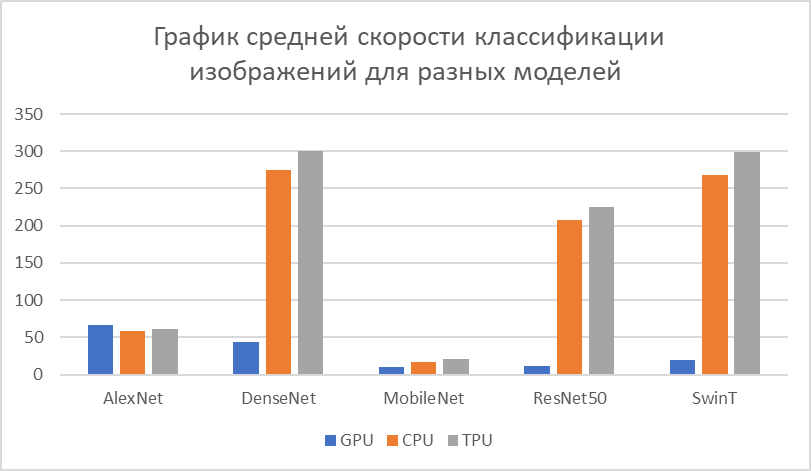

Видим, что в основном наименьшее время распознавания у среды выполнения GPU.

Ни одна из моделей не идентифицировала изображения правильно, соответственно, точность распознавания для данного датасета будет равна 0.

Проверим еще раз скорость выполнения в разных моделях. Среднее время классификации немного увеличилось, возможно из-за загруженности сервера. В модели AlexNet среднее время выполнения в GPU выше, чем в CPU. Возможно, это связано с тем, что AlexNet самая ранняя модель среди представленных, и она хуже всех оптимизирована. Помимо этого, база данных AlexNet содержит 1000 классов, что меньше количества классов в остальных моделях. Также AlexNet содержит меньше слоев, чем остальные представленные модели. Возможно, совокупность этих факторов и нашего достаточно специализированного датасета обуславливает такое необычное распределение скоростей на диаграмме.

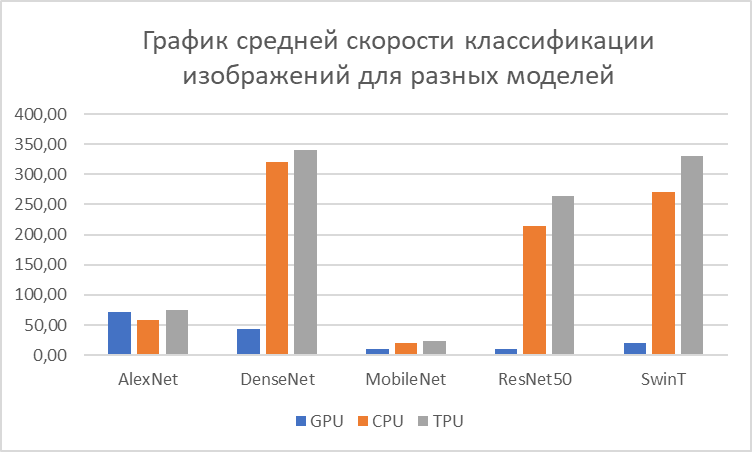

# Подготовка датасета для донастройки модели

Проведем донастройку слоя классификации для модели SwinT на собранном датасете, а затем выполним классификацию. Для этого разобъем весь датасет на часть для настройки (80% датасета или 40 изображений каждого класса) и часть для валидации (20% датасета или 10 изображений каждого класса).

In [ ]:
%%writefile train.csv
label;url
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_1?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_2?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_3?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_4?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_5?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_6?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_7?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_8?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_9?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_10?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_11?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_12?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_13?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_14?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_15?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_16?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_17?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_18?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_19?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_20?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_21?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_22?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_23?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_24?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_25?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_26?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_27?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_28?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_29?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_30?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_31?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_32?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_33?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_34?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_35?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_36?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_37?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_38?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_39?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/train/train.csv_image_40?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_1?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_2?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_3?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_4?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_5?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_6?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_7?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_8?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_9?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_10?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_11?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_12?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_13?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_14?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_15?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_16?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_17?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_18?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_19?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_20?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_21?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_22?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_23?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_24?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_25?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_26?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_27?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_28?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_29?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_30?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_31?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_32?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_33?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_34?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_35?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_36?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_37?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_38?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_39?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/train/train.csv_image_40?raw=true

In [ ]:
%%writefile test.csv
label;url
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_1?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_2?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_3?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_4?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_5?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_6?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_7?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_8?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_9?raw=true
коробка передач;https://github.com/Olgera/potential-happiness/blob/master/%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87/test/test.csv_image_10?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_1?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_2?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_3?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_4?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_5?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_6?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_7?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_8?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_9?raw=true
ротор турбины;https://github.com/Olgera/potential-happiness/blob/master/%D1%80%D0%BE%D1%82%D0%BE%D1%80%20%D1%82%D1%83%D1%80%D0%B1%D0%B8%D0%BD%D1%8B/test/test.csv_image_10?raw=true

Датасет в библиогтеки PyTorch представлен базовым классом Dataset, описывающий способ загрузки и трансформации набора данных по запросу.
Начнем с описания процесса "подгрузки" изображений по url и лэйблу из CSV-файла с описанием датасета.

После подготовки класса со сценарием загрузки изображений, его можно проверить путем визуализации с помощью библиотеки Matplotlib.

In [ ]:
transform = model['preprocess']
train = UrlDataset("train.csv", device, transform)
test = UrlDataset('test.csv', device, transform)
simple = UrlDataset("simple.csv", device, transform)
num_per_row = 5
single_size = 3.5
vspace = 0.3

print('-'*70)
print(f'Model: { model["model"].__class__.__name__}')
print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

print('-'*30  + ' Train dataset ' + '-'*30)
classify(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = train.classes, model=model['model'], model_labels=model['weights'].meta["categories"])
print('-'*30  + ' Test dataset ' + '-'*30)
classify(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = test.classes, model=model['model'], model_labels=model['weights'].meta["categories"])

Как видно из результата, зачастую стандартный набор классов известных датасетов не покрывает нужные в специфических задачах. Тем не менее есть эффективный способ донастройки модели, который на практике позволяет с одной стороны воспользоваться результатом оптимизации предобученных моделей, с другой - адаптировать их под специфические задачи.

# Предобученная нейронная сеть как генератор признаков




Наиболее простой способ адаптации предобученных моделей к специфической задаче это переобучение выходного классификатора, который вычисляет принадлежность изображения к тому или иному классу. Это возможно благодаря особенности глубоких нейронных сетей, состоящей в том, что по мере преобразования между слоями происходит постепенный переход от конкретного изображения как набора пикселей к более обощённому представлению (пространство признаков), инвариантных к второстепенной информации (фон, повороты, растяжения, освещенность и т.д.). Таким образом, выходной слой лишь использует обобщённое пространство признаков для разделения на области, относящиеся к разным классам объектов. И если цель состоит в создании иного разбиения, то достаточно заменить выходной слой на новый классификатор, настроив его на распознавание нужных классов объктов.

Популярным способом разбиения пространства признаков в случае существенно отличающихся классов является использование линейной гиперповерхности (линейный классификатор). Его преимуществом является простота и как следствие эффективность на небольших выборках. Основной недостаток - невозможность реализации сложных разбиений между близкими классами объектов. Для визуальной проверки возможности применения линейного классификатора в конкретной задаче можно использовать метод редукции многомерного пространства признаков, полученных на выходе предпоследнего слоя предобученной модели.

В моделях библиотеки PyTorch для этого с учетом фиксированной последовательности слоев (специфика библиотеки) необходимо отключить слой классификации, заменив его на единичное преобразование. В таком виде модель нейросети будет играть роль генератора признаков.




В первую очередь рассмотрим структуру модели и найдем в ней выходной классификатор

In [ ]:
print(model)

Выходной слой это classifier (зачастую это даже не один слой, а группа слоев, наделяющих классификатор нужными свойствами).
Уберем его, чтобы получить на выходе набор признаков. Для этого заменим выходной классификатор на единичное преобразование.

In [ ]:
image, label = simple[0]
feature_extractor = copy.deepcopy(model['model'])
result = feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()
print(f'Размерность выходов исходной модели: {result.shape}')
setattr(feature_extractor, model['output_layer'], nn.Identity())
result = feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()
print(f'Размерность выходов модели после замены выходного классификатора на единичное преобразование: {result.shape}')

Попробуем визуализировать каким-либо образом пространство признаков, обозначая объекты целевых классов разными цветами. Общая гипотеза состоит в том, что  изображения разных классов должны лежать в разных областях пространства признаков (т.е. они выглядят как сосредоточенные "облака" точек, которые в свою очередь расположены на значительном удвлении друг от друга). В этом случае с помощью линейной гиперплоскости можно спроецировать точки в N-мерном пространстве признаков на эту плоскость и получить одно-, двух- или трехмерные проекции этих облаков, которые уже можно визуализировать на графике. Таким образом, для проверки гипотезы достаточно убедиться, что проекции "облаков" разных классов будут визуально изолированы. В этом случае перенастройка линейного классификатора на выходе нейронной сети приведет к решению задачи классификации на индивидуальной выборке объектов.

Чтобы получить двухмерную проекцию точек пространства признаков воспользуемся методом редукции размерности на основе метода линейного PCA (Principial Component Analysis). Суть его состоит в отыскании такой линейной гиперплоскости в N-мерном пространстве, расстояние до которой всех точек будет минимальным (т.е. она максимально аппроксимирует данные). Координаты спроецированных точек в пространстве этой гиперповерхности как раз и являются искомым двухмерным представлением "облаков", характеризующих разные классы объектов выборки.

Итак, первым делом преобразуем имеющиеся списки изображений в массивы признаков и лэйблов классов.

In [ ]:
output = []
for image, label in torch.utils.data.ConcatDataset([train, test]):
    result = {'label': label, 'feature': feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()}
    output.append(result)
features = numpy.concatenate([numpy.expand_dims(record['feature'], 0) for record in output])
labels = [record['label'] for i, record in enumerate(output)]

Далее применим PCA-метод, который на основе N-мерных массивов признаков вычислит координаты точек на гиперплоскости (U), список собственных чисел (S) и собственных векторов (V) для преобразования координат между основным и редуцированным пространством.

In [ ]:
totalU, totalS, totalV = torch.pca_lowrank(torch.from_numpy(features), q=2)

Для визуализации остается совершить трансформации осей массивов, чтобы получить ряды для координат абсцис и ординат графика, а также разделить массивы точек разных классов, чтобы каждому задать свой цвет.

In [ ]:
series = {}
for key in ['коробка передач', 'ротор турбины']:
    points = numpy.concatenate([numpy.expand_dims(totalU[i,:].cpu().detach().numpy(), 0)
        for i, label in enumerate(labels) if train.classes[label] == key])
    series[key] = numpy.moveaxis(points, 1, 0)

plt.figure()
plt.plot(series['коробка передач'][0], series['коробка передач'][1], 'ro', series['ротор турбины'][0], series['ротор турбины'][1], 'bo')
plt.legend(['коробка передач', 'ротор турбины'])
plt.show()

На графике выше видно, что на двухмерной проекции точки разных классов лежат в разных областях с небольшой погрешностью и могут быть разделены прямой. Это означает, что применение линейного классификатора в данном случае выглядит оправданным.

## Донастройка модели под специфическую задачу классификации

Донастройка происходит за счет переобучения выходных слоев глубинной нейронной сети, отвечающих за различие частных деталей разных классов (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

Мы будем использовать простейший классификатор - линейный, который играет роль гиперплоскости в N-мерном пространстве, разделющей пространство признаков на 2 части. Преимуществом такого классификатора является его простота, высокая скорость обучения, а также нужный результат даже при небольшом наборе данных (здесь действует эмпирическое правило: чем проще модель, тем меньше данных нужно для её обучения). Основной недостаток линейного классификатора - недостаточная сложность для случаев, когда классы визуально близки, отличаясь только нюансами. В таких ситуациях гиперплоскость является слишком простой моделью и необходимо использовать нелинейную гиперповерхность (нелинейный классификатор).

Так как мы не планируем менять коэффициенты предобученных слоев, первым делом необходимо отключить их перенастройку.

In [ ]:
tunned_model = copy.deepcopy(model['model'])
for param in tunned_model.parameters():
    param.requires_grad = False

Затем добавим новый слой-классификатор на выходе

In [ ]:
print(tunned_model)

In [ ]:
print(getattr(tunned_model, model['output_layer']))

In [ ]:
in_features = model['in_features'](tunned_model)
print(in_features)

Теперь добавим линейный классификатор с нужным числом входов и двумя выходами. Выход классификатора пропустим через Softmax слой, чтобы получить на вызоде нормированный сигнал из диапазона [0;1].

In [ ]:
setattr(tunned_model, model['output_layer'], torch.nn.Sequential(torch.nn.Linear(in_features, 2), torch.nn.Softmax(dim=1)))

In [ ]:
print(tunned_model)

In [ ]:
print(f"num of adjustable parameters = {sum(i.numel() for i in getattr(tunned_model, model['output_layer']).parameters())}")

Для запуска процесса обучения необходим вспомогательный класс-обертка Dataloader, который позволяет объединять и разбивать наборы данных, заданные с помощью Dataset на фрагменты. Это необходимо, например, для параллелизации процесса настройки в ансамблях моделей, когда выборка разбивается на подвыборки и настройка происходит в  независимых процессах.

In [ ]:
dataloader = [
    {
        'train': True,
        'loader': DataLoader(train, batch_size=1, shuffle=True, num_workers=0)
    },
    {
        'train': False,
        'loader': DataLoader(test, batch_size=1, shuffle=True, num_workers=0)
    }
]

Создадим критерий, оптимизатор и динамически изменяемый коэффициент усиления процесса обучения.

In [ ]:
tunned_model.to(device)
critery = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(getattr(tunned_model, model['output_layer']).parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5,verbose=True)

In [ ]:
print(tunned_model)

Наконец, проведем перенастройку

In [ ]:
model_conv, process = train_model(model=tunned_model, dataloader=dataloader, device=device,
                         critery=critery, optimizer=optimizer, scheduler=lr_scheduler,
                         num_epochs=9)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(16,10), sharex=True)
axs[0,0].plot(process['train']['loss'])
axs[0,0].title.set_text('Эволюции ошибки на выборке для обучения')
axs[0,1].plot(process['train']['accuracy'])
axs[0,1].title.set_text('Эволюции ошибки на выборке для обучения')
axs[1,0].plot(process['validate']['loss'])
axs[1,0].title.set_text('Эволюции ошибки на выборке для проверки')
axs[1,1].plot(process['validate']['accuracy'])
axs[1,1].title.set_text('Эволюции ошибки на выборке для проверки')
axs[1,0].set_xlabel('Итерация обучения')
axs[1,1].set_xlabel('Итерация обучения')
axs[0,0].set_ylabel('Значение ошибки')
axs[1,0].set_ylabel('Значение ошибки')

Выведем результат после обучения

In [ ]:
print('-'*30  + ' Train dataset ' + '-'*30)
classify(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = train.classes, model=tunned_model, model_labels=train.classes, debug=True  )
print('-'*30  + ' Test dataset ' + '-'*30)
classify(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = test.classes, model=tunned_model, model_labels=test.classes)

После обучения модель SwinT все изображения распознала правильно, соответственно, точность распознавания изображений - 100%, в отличие от базовой преднастроенной модели, где точность была 0%. Степень уверенности в тренировочной и тестовой выборке по большей части составляет 73%.